In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from __future__ import division
from random import choice
from math import log, sqrt
from numpy.random import randint

In [6]:
class Board(object):
    def __init__(self, n, m, d, Rs, Rc, O):
        self.n = n
        self.m = m
        self.d = d
        self.Rs = Rs
        self.Rc = Rc
        self.Rs2 = tuple(np.array(Rs)**2)
        self.Rc2 = tuple(np.array(Rc)**2)
        self.O = O
        O2 = []
        for x1, y1, x2, y2 in O:
            for x in range(x1, x2+1):
                for y in range(y1, y2+1):
                    O2.append((x, y))
        self.O2 = O2
        self.O2set = set(O2)
        Cov = [[] for r in range(10)]
        for r in range(10):
            for x in range(-r, r):
                for y in range(-r, r):
                    if x*x + y*y <= r*r:
                        Cov[r].append((x, y))
        self.Cov = Cov
    
    def start(self):
        # Returns a representation of the starting state of the game.
        return [(-1,-1)] * self.m

    def next_state(self, state, play):
        # Takes the game state, and the move to be applied.
        # Returns the new game state.
        try:
            t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
        except StopIteration:
            return state
        state_copy = state[:]
        state_copy[t] = play
        return state_copy

    def legal_plays(self, state_history):
        # Takes a sequence of game states representing the full
        # game history, and returns the full list of moves that
        # are legal plays for the current player.
        state = state_history[-1]
        legal = []
#         try:
#             t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
#         except StopIteration:
#             return []
        n = self.n
        m = self.m
        Rs = self.Rs
        Rc = self.Rc
        Rs2 = self.Rs2
        Rc2 = self.Rc2
        Cov = self.Cov
        t = -1
        for i in range(m):
            try:
                x, y = state[i]
            except TypeError:
                return []
            if x < 0 or y < 0:
                t = i
                break
        if t == -1:
            return []
        if t == 0:
            # First iteration anywhere but inside obstacles
            for j in range(0, n+1):
                for k in range(0, n+1):
                    if (j, k) not in self.O2set:
                        legal.append((j, k))
        else:
            # Loop through deployed positions
            for i in range(0, t):
                x, y = state[i]
                # Eliminate out of bound positions
                if x < 0 or y < 0 or x > n or y > n:
                    continue
                # Loop through possible deploy positions
                # (j, k) = possible position
                for j in range(x - Rc[i] - Rc[t] + 1, x + Rc[i] + Rc[t]):
                    for k in range(y - Rc[i] - Rc[t] + 1, y + Rc[i] + Rc[t]):
                        # Eliminate out of bound positions
                        if j < 0 or k < 0 or j > n or k > n:
                            continue
                        # Eliminate deployed positions
                        if (j, k) in state:
                            continue
                        # Eliminate inside obstacles
                        if (j, k) in self.O2set:
                            continue
                        overlap = []
                        # Loop through possible coverage
                        # (u, v) = points in sensor i
                        # Need to determine if (u, v) is in coverage of sensor t deployed at (j,k)
#                         for u in range(x - Rc[i], x + Rc[i] + 1):
#                             for v in range(y - Rc[i], y + Rc[i] + 1):
#                                 # Eliminate out of bound
#                                 if u < 0 or v < 0 or u > n or v > n:
#                                     continue
#                                 # Eliminate out of circle
#                                 if (u-x)*(u-x) + (v-y)*(v-y) > Rc2[i]:
#                                     continue
#                                 # Determine if (u,v) is covered by sensor t
#                                 if (u-j)*(u-j) + (v-k)*(v-k) <= Rc2[t]:
#                                     overlap.append((u, v))
                        for u, v in Cov[Rc[i]]:
                            if (u+x-j)*(u+x-j) + (v+y-k)*(v+y-k) <= Rc2[t]:
                                overlap.append((u, v))
                        if len(overlap) >= 2 and set(overlap).issubset(self.O2set) is False:
                            legal.append((j,k))
        return legal

    def winner(self, state_history):
        # Takes a sequence of game states representing the full
        # game history.  If the game is now won, return the player
        # number.  If the game is still ongoing, return zero.  If
        # the game is tied, return a different distinct value, e.g. -1.
        pass

In [57]:
class MonteCarlo(object):
    def __init__(self, board, **kwargs):
        # Takes an instance of a Board and optionally some keyword
        # arguments.  Initializes the list of game states and the
        # statistics tables.
        self.board = board
        self.states = []
        seconds = kwargs.get('time', 30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves', 100)
        self.C = kwargs.get('C', 1.4)
        self.scores = {}
        self.plays = {}
        pass

    def update(self, state):
        # Takes a game state, and appends it to the history.
        self.states.append(state)
        pass

    def get_play(self):
        # Causes the AI to calculate the best move from the
        # current game state and return it.
        self.max_depth = 0
        state = self.states[-1]
        legal = self.board.legal_plays(self.states[:])

        # Bail out early if there is no real choice to be made.
        if not legal:
            return
        if len(legal) == 1:
            return legal[0]

        games = 0
        begin = datetime.datetime.utcnow()
        while datetime.datetime.utcnow() - begin < self.calculation_time:
            self.run_simulation()
            games += 1

        moves_states = [(p, self.board.next_state(state, p)) for p in legal]

        # Display the number of calls of `run_simulation` and the
        # time elapsed.
#         print(games, datetime.datetime.utcnow() - begin)

        # Pick the move with the highest score.
        percent_scores, move = max(
            (self.scores.get(tuple(S), 0) /
             self.plays.get(tuple(S), 1),
             p)
            for p, S in moves_states
        )

        # Display the stats for each possible play.
#         for x in sorted(
#             ((self.scores.get(tuple(S), 0) /
#               self.plays.get(tuple(S), 1),
#               self.scores.get(tuple(S), 0),
#               self.plays.get(tuple(S), 0), p)
#              for p, S in moves_states),
#             reverse=True
#         ):
#             print ("{3}: {0:.2f} ({1} / {2})".format(*x))

#         print ("Maximum depth searched:", self.max_depth)

        return move

    def run_simulation(self):
        # Plays out a "random" game from the current position,
        # then updates the statistics tables with the result.
        
        # A bit of an optimization here, so we have a local
        # variable lookup instead of an attribute access each loop.
        plays, scores = self.plays, self.scores

        visited_states = set()
        states_copy = self.states[:]
        state = states_copy[-1]

        expand = True
        for t in range(1, self.max_moves + 1):
            legal = self.board.legal_plays(states_copy)
            
            moves_states = [(p, self.board.next_state(state, p)) for p in legal]
            
            if not moves_states:
                continue

            if plays.get(tuple(state)) and plays[tuple(state)] >= 10 and all(plays.get(tuple(S)) for p, S in moves_states):
                # If we have stats on all of the legal moves here, use them.
                log_total = log(
                    sum(plays[tuple(S)] for p, S in moves_states)
                )
                value, move, state = max(
                    ((scores[tuple(S)] / plays[tuple(S)]) +
                     self.C * sqrt(log_total / plays[tuple(S)]), p, S)
                    for p, S in moves_states
                )
            else:
                # Otherwise, just make an arbitrary decision.
                move, state = choice(moves_states)

            states_copy.append(state)

            if expand and tuple(state) not in plays:
                expand = False
                plays[tuple(state)] = 0
                scores[tuple(state)] = 0
                if t > self.max_depth:
                    self.max_depth = t

            visited_states.add(tuple(state))

#             winner = self.board.winner(states_copy)
#             if winner:
#                 break

        for state in visited_states:
            if tuple(state) not in plays:
                continue
            plays[tuple(state)] += 1
            cov = 0
            cov_list = []
            for x in range(self.board.n+1):
#                 for y in range(self.board.n+1):
#                     for i in range(self.board.m):
#                         j, k = state[i]
#                         if (x-j)*(x-j) + (y-k)*(y-k) <= self.board.Rs2[i]:
#                             cov += 1
#                             break
                for y in range(self.board.n+1):
                    for i in range(self.board.m):
                        j, k = state[i]
                        if (x-j)*(x-j) + (y-k)*(y-k) <= self.board.Rs2[i]:
                            cov_list.append((x,y))
                            break
            cov_set = set(cov_list).difference(board.O2set)
            cov = len(cov_set)
            scores[tuple(state)] += cov

18
8436 26970 0.3127919911012236 3.132218837738037 21


<IPython.core.display.Javascript object>


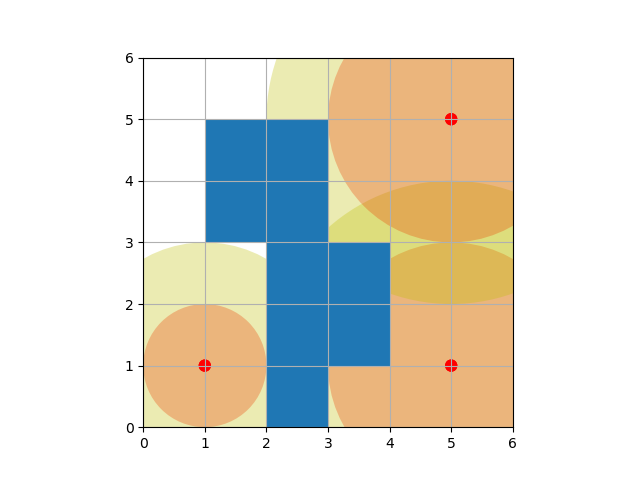

In [417]:
# n = 6
# m = 3
# d = 3
# Rs = tuple(randint(1,3,size=m))
# Rc = tuple(np.array(Rs) + randint(1,2,size=m))
# O = []
# for i in range(d):
#     x1, y1 = tuple(np.random.randint(0,n-2,size=2))
#     x2 = np.random.randint(x1+1, x1+3)
#     y2 = np.random.randint(y1+1, y1+3)
#     O.append((x1, y1, x2, y2))
n = 6
m = 3
d = 2
Rs = (1, 1, 2)
Rc = (2, 2, 3)
O = [(2,1,4,3), (3, 3, 4, 5)]
board = Board(n, m, d, Rs, Rc, O)
Rs2 = board.Rs2
Rc2 = board.Rc2
Cov = board.Cov
history = [[] for i in range(m+1)]
history[0] = [board.start()]

start = time.time()
for i in range(0, m):
    for state in history[i]:
        legal_plays = board.legal_plays([state])
        if not legal_plays:
            continue
        for play in legal_plays:
            next_state = board.next_state(state, play)
            if next_state not in history[i+1]:
                history[i+1].append(next_state)

possibles = history[-1]

count = len(possibles)
obstacle_points = len([(x, y) for x, y in board.O2set if x <= n and y <= n])
print(obstacle_points)
worst = 1
for i in range(0, m):
    worst *= (n+1)*(n+1) - obstacle_points - i


max_cov = 0
max_deploy = None
for deploy in possibles:
    cov = 0
    cov_list = []
    for x in range(n+1):
        for y in range(n+1):
            for i in range(m):
                j, k = deploy[i]
#                 if (x, y) in board.O2set:
#                     continue
                if (x-j)*(x-j) + (y-k)*(y-k) <= Rs2[i]:
                    cov_list.append((x,y))
                    break
    cov_set = set(cov_list).difference(board.O2set)
    cov = len(cov_set)
#     cov_set = set()
#     for i in range(m):
#         x, y = deploy[i]
#         cov_set_i = {(x+j, y+k) for j, k in Cov[i] if (x+j, y+k) not in board.O2set}
#         cov_set.update(cov_set_i)
#     cov = len(cov_set)
    if cov > max_cov:
        max_deploy = deploy[:]
        max_cov = cov

end = time.time()

print(count, worst, count/worst, end-start, max_cov)
        
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(which='both')
ax.set_aspect('equal')
ax.set_xticks(np.arange(0,n+1,1))
ax.set_yticks(np.arange(0,n+1,1))

for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=Rs[i], fc='r', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=Rc[i], fc='y', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

for j in range(0, d):
    x1, y1, x2, y2 = O[j]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1)
    plt.gca().add_patch(rect)
    
for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

plt.show()
plt.savefig('4.2.4.png')

t 0.01 z 0
t 0.01 z 1
t 0.01 z 2
t 0.01 z 3
t 0.01 z 4
t 0.01 z 5
t 0.01 z 6
t 0.01 z 7
t 0.01 z 8
t 0.01 z 9


<IPython.core.display.Javascript object>


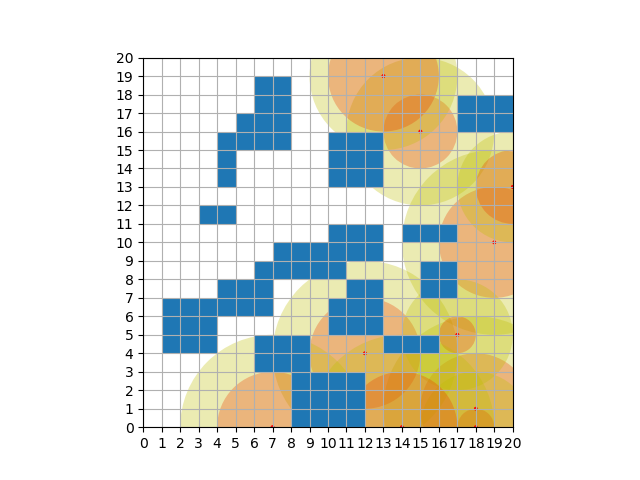

103.0


<IPython.core.display.Javascript object>


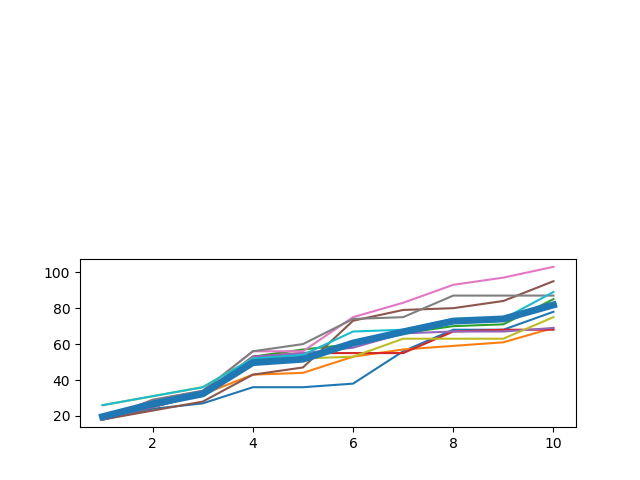

max_cov 103.0 std 11.364858116140297
t 0.1 z 0
t 0.1 z 1
t 0.1 z 2
t 0.1 z 3
t 0.1 z 4
t 0.1 z 5
t 0.1 z 6
t 0.1 z 7
t 0.1 z 8
t 0.1 z 9


<IPython.core.display.Javascript object>


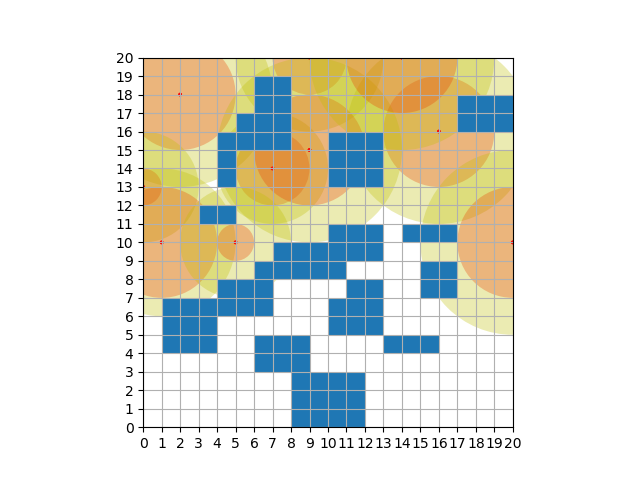

124.0


<IPython.core.display.Javascript object>


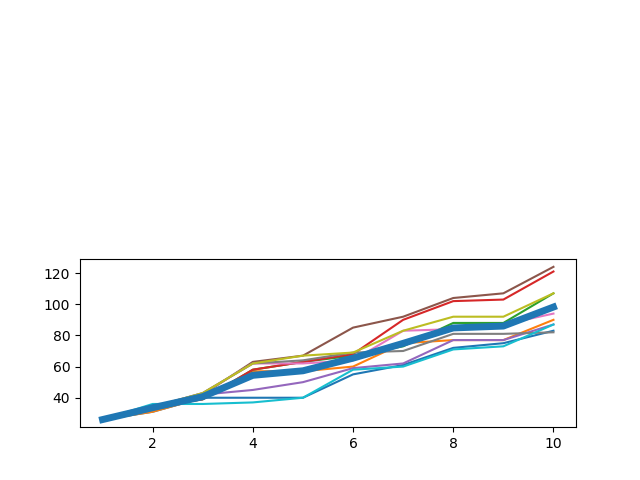

max_cov 124.0 std 14.729562111617577
t 1 z 0
t 1 z 1
t 1 z 2
t 1 z 3
t 1 z 4
t 1 z 5
t 1 z 6
t 1 z 7
t 1 z 8
t 1 z 9


<IPython.core.display.Javascript object>


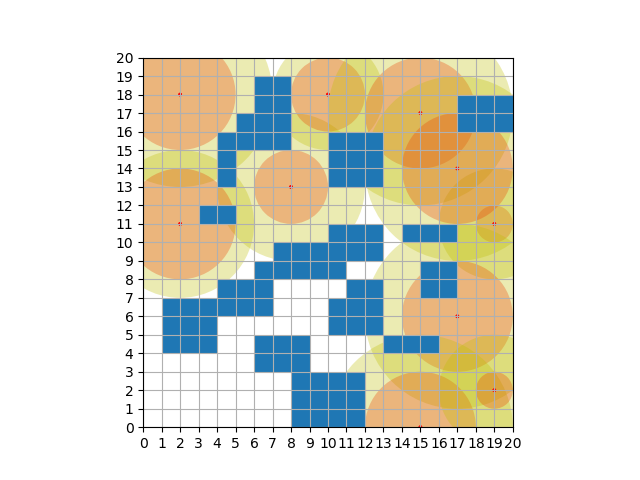

155.0


<IPython.core.display.Javascript object>


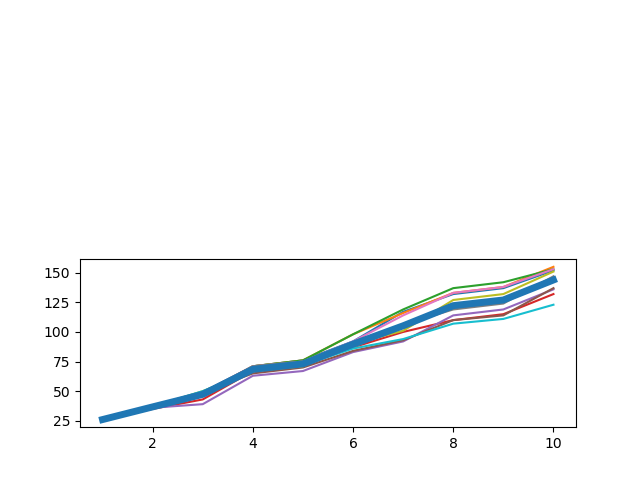

max_cov 155.0 std 10.501904589168577
t 10 z 0
t 10 z 1
t 10 z 2
t 10 z 3
t 10 z 4
t 10 z 5
t 10 z 6
t 10 z 7
t 10 z 8
t 10 z 9


<IPython.core.display.Javascript object>


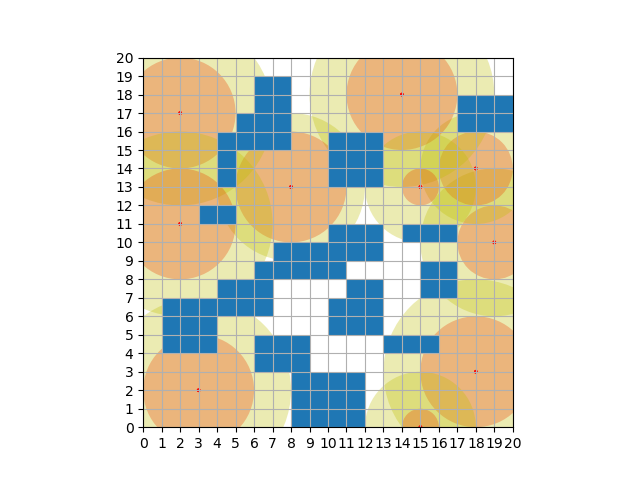

170.0


<IPython.core.display.Javascript object>


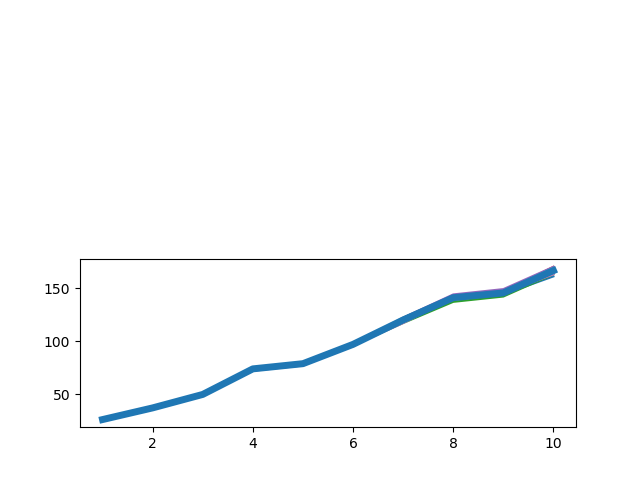

max_cov 170.0 std 3.039736830714133


In [65]:
n = 20
m = 10
d = 20
Rs = (3, 2, 2, 3, 1, 3, 3, 3, 1, 3)
Rc = (5, 4, 3, 5, 3, 4, 5, 5, 3, 5)
O = [(3, 11, 5, 12), (6, 6, 7, 9), (7, 8, 8, 10), (6, 3, 9, 5), (8, 0, 11, 3), (5, 15, 8, 17), (9, 0, 12, 3), (17, 16, 20, 18), (10, 13, 13, 16), (8, 8, 11, 10), (11, 6, 13, 8), (4, 6, 6, 8), (10, 9, 13, 11), (6, 16, 8, 19), (13, 4, 16, 5), (10, 5, 13, 7), (15, 7, 17, 9), (1, 4, 4, 7), (4, 13, 5, 16), (14, 10, 17, 11)]
# Rs = tuple(np.random.randint(1,4,size=m))
# Rc = tuple(np.array(Rs) + np.random.randint(1,3,size=m))
# O = []
# for i in range(d):
#     x1, y1 = tuple(np.random.randint(0,n-2,size=2))
#     x2 = np.random.randint(x1+1, x1+4)
#     y2 = np.random.randint(y1+1, y1+4)
#     O.append((x1, y1, x2, y2))
# n = 6
# m = 3
# d = 3
# Rs = (2, 1, 2)
# Rc = (3, 2, 3)
# O = [(2, 0, 3, 2), (2, 1, 4, 3), (1, 3, 3, 5)]

board = Board(n, m, d, Rs, Rc, O)

Rc2 = board.Rc2
Rs2 = board.Rs2

montecarlo = MonteCarlo(board, time=0.1)

limits = [0.01, 0.1, 1, 10]
tries = 10
cov_growth = np.zeros((tries, m))
max_cov = 0
max_deploy = None
for t in limits:
    for z in range(tries):
        print("t", t, "z", z)
        montecarlo.calculation_time = datetime.timedelta(seconds=t)
        montecarlo.update(board.start())
        for i in range(0, m):
            move = montecarlo.get_play()
        #     print('This is move', move)
            next_state = board.next_state(montecarlo.states[-1], move)
        #     print('This is next state', next_state)
            montecarlo.update(next_state)

        deploy = montecarlo.states[-1]

        # print(max_deploy)
        cov_list = []
        for i in range(m):
            j, k = deploy[i]
            for x in range(n+1):
                for y in range(n+1):
                    if (x-j)*(x-j) + (y-k)*(y-k) <= Rs2[i]:
                        cov_list.append((x,y))
            cov_set = set(cov_list).difference(board.O2set)
            cov = len(cov_set)
            cov_growth[z][i] = cov

        if cov_growth[z][-1] > max_cov:
            max_cov = cov_growth[z][-1]
            max_deploy = deploy[:]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.grid(which='both')
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0,n+1,1))
    ax.set_yticks(np.arange(0,n+1,1))

    print(max_cov)

    for i in range(0, m):
        x, y = max_deploy[i]
        circle = plt.Circle((x, y), radius=Rs[i], fc='r', alpha=0.3)
        plt.gca().add_patch(circle)
        circle = plt.Circle((x, y), radius=Rc[i], fc='y', alpha=0.3)
        plt.gca().add_patch(circle)
        circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
        plt.gca().add_patch(circle)

    for j in range(0, d):
        x1, y1, x2, y2 = O[j]
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1)
        plt.gca().add_patch(rect)

    for i in range(0, m):
        x, y = max_deploy[i]
        circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
        plt.gca().add_patch(circle)

    plt.savefig('plot_maxdeploy_'+str(t)+'.png')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(2,1,2)
    x = np.arange(1, m+1, 1)
    cov_growth_mean = np.mean(cov_growth, axis=0)
    std = np.std(cov_growth, axis=0)
    for i in range(tries):
        ax2.plot(x, cov_growth[i])
    ax2.plot(x, cov_growth_mean, linewidth=5.0)
    print("max_cov", max_cov, "std", std[-1])

    plt.show()
    plt.savefig('plot_allcov_'+str(t)+'.png')

In [300]:
plt.savefig('sample.png')

In [56]:
np.fromstring('[[ 25.  33.  35.  51.  55.  62.  80.  91.  94. 114.]\
 [ 25.  33.  35.  51.  55.  69.  83.  84.  87.  90.]\
 [ 25.  33.  40.  52.  56.  62.  79.  84.  86. 104.]\
 [ 25.  34.  39.  39.  39.  40.  51.  72.  77.  89.]\
 [ 25.  34.  39.  40.  44.  54.  75.  77.  80.  94.]\
 [ 26.  29.  31.  37.  42.  56.  62.  72.  75.  77.]\
 [ 26.  31.  32.  44.  47.  68.  71.  73.  74.  77.]\
 [ 26.  34.  36.  53.  54.  54.  59.  59.  62.  63.]\
 [ 26.  34.  37.  48.  50.  53.  53.  54.  56.  79.]\
 [ 26.  34.  38.  54.  57.  59.  82.  86.  91. 105.]]')

C:\Users\Woratham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


ValueError: string size must be a multiple of element size

In [64]:
print(Rs)
print(Rc)
print(O)

(3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 1, 2, 1, 2, 3)
(4, 4, 5, 3, 3, 4, 3, 4, 4, 4, 4, 3, 5, 4, 3, 2, 3, 3, 4, 4)
[(5, 9, 8, 11), (18, 19, 19, 20), (17, 15, 20, 18), (18, 3, 20, 4), (26, 16, 29, 19), (30, 2, 31, 4), (4, 4, 7, 7), (10, 2, 12, 3), (15, 35, 18, 36), (10, 20, 11, 21), (10, 21, 11, 22), (11, 36, 14, 39), (18, 23, 21, 24), (1, 12, 2, 13), (19, 34, 20, 37), (17, 13, 20, 14), (31, 37, 33, 38), (36, 2, 37, 5), (19, 10, 20, 13), (6, 14, 9, 17), (0, 34, 3, 36), (11, 7, 12, 10), (8, 25, 10, 26), (5, 33, 7, 36), (33, 20, 36, 22), (29, 29, 31, 31), (27, 16, 29, 18), (6, 34, 9, 36), (15, 22, 16, 23), (7, 12, 9, 13), (2, 27, 3, 29), (6, 24, 9, 26), (6, 21, 9, 23), (2, 2, 5, 3), (29, 30, 30, 32), (9, 27, 11, 29), (26, 12, 29, 14), (8, 27, 10, 29), (32, 36, 34, 37), (5, 11, 7, 13), (29, 6, 31, 8), (6, 17, 7, 20), (26, 35, 29, 38), (32, 1, 35, 4), (22, 14, 24, 17), (35, 22, 36, 23), (36, 3, 38, 5), (16, 1, 17, 2), (34, 0, 35, 1), (1, 36, 3, 38), (8, 21, 11, 23), (4, 4, 6, 6), (29